In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mytest1logistic/customer_churn.csv
/kaggle/input/houkong-moai/customer_churn.csv
/kaggle/input/knntest/KNNAlgorithmDataset.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, fbeta_score)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
# 区域2：路径配置=====================================================
TRAIN_PATH = "/kaggle/input/mytest1logistic/customer_churn.csv"  # 训练集
OUTPUT_PATH = "/kaggle/working/predictions.csv"  # 结果文件路径

In [4]:
# 区域3：数据加载与预处理=============================================
# 加载训练集
train_data = pd.read_csv(TRAIN_PATH)
X = train_data.drop(['customer_id', train_data.columns[-1]],axis=1) 
y = train_data.iloc[:, -1]

numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])


In [6]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,        # 树数量（原KNN的n_neighbors=5删除）
        max_depth=8,             # 控制模型复杂度
        class_weight='balanced', # 处理类别不平衡
        random_state=42,        
        n_jobs=-1               # 启用多核加速
    ))  
])


param_grid = {
    'classifier__n_estimators': [100, 200, 300],       # 树数量范围
    'classifier__max_depth': [5, 8, 10, None],          # 深度控制复杂度
    'classifier__min_samples_split': [2, 5],            # 节点分裂最小样本数
    'classifier__class_weight': ['balanced', None]     # 处理类别不平衡
}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,              # 使用原有预处理管道
    param_grid=param_grid, 
    cv=5,                            # 5折交叉验证
    scoring='f1_weighted',           # 根据业务需求选择评估指标
    n_jobs=-1,                       # 启用多核并行加速
    verbose=2                        # 输出调优过程日志
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.7s
[CV] END classifier__class_weigh

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'subscription_length', 'monthly_bill', 'total_usage',
       'service_complaints'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['gender'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=8,
                                                               n_estimators=200,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [5, 8, 10, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='f1_weighted', verbose=2)

In [7]:
best_model = grid_search.best_estimator_
print(f"最佳参数组合: {grid_search.best_params_}") 
print(f"交叉验证最高得分: {grid_search.best_score_:.4f}")

最佳参数组合: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
交叉验证最高得分: 0.8770


In [8]:
def generate_metrics(y_true, y_pred, prefix=""):
    return {
        f"{prefix}Accuracy": accuracy_score(y_true, y_pred),
        f"{prefix}Precision": precision_score(y_true, y_pred, average='weighted'),
        f"{prefix}Recall": recall_score(y_true, y_pred, average='weighted'),
        f"{prefix}F1": f1_score(y_true, y_pred, average='weighted'),
        f"{prefix}F2": fbeta_score(y_true, y_pred, beta=2, average='weighted')
    }

val_pred = best_model.predict(X_val)
metrics_report = generate_metrics(y_val, val_pred, "VAL_")
print(metrics_report)

{'VAL_Accuracy': 0.895, 'VAL_Precision': 0.8837087912087912, 'VAL_Recall': 0.895, 'VAL_F1': 0.885830985915493, 'VAL_F2': 0.890687316116378}


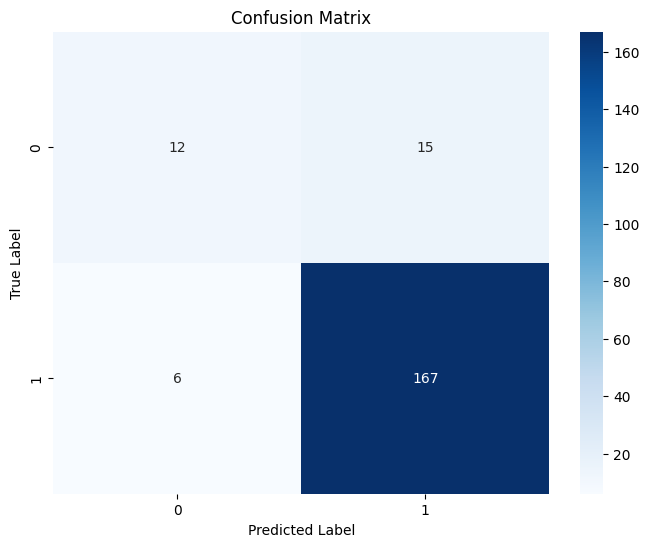

In [9]:
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
output_df = pd.DataFrame({
    'ID': train_data['customer_id'],
    'Churn': best_model.predict(X)
})
output_df.to_csv(OUTPUT_PATH, index=False, header=True)

joblib.dump(best_model, '/kaggle/working/model.pkl')
print(f"预测结果已保存至：{OUTPUT_PATH}")

预测结果已保存至：/kaggle/working/predictions.csv
